In [10]:
#DEEP ANALYSIS OF SENTIMENTS
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import nltk 
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings("ignore")

In [11]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [14]:
train = pd.read_csv("trains.csv")
test = pd.read_csv("test.csv")
train.sample(2)

,id,label,tweet
5435,5436,0,"welfare mom, shop lifter &amp; #trump mouthpie..."
23310,23311,0,left my john smiths holdall on the train. #s...


In [15]:
train.shape, test.shape


((31962, 3), (17197, 2))

In [16]:
df = train.append(test, ignore_index = True)
df.shape

(49159, 3)

In [17]:
#Remove twitter handlers i.e., @user
train['cleaned_tweet'] = train.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))
test['cleaned_tweet'] = test.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

In [18]:
#HASHTAGS
#Positive Words
#Select all words from normal tweet
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
#Collect all hashtags
pos_htag = [htag for htag in normal_words.split() if htag.startswith('#')]
#Remove hashtag symbol (#)
pos_htag = [pos_htag[i][1:] for i in range(len(pos_htag))]
#Count frequency of each word
pos_htag_freqcount = nltk.FreqDist(pos_htag)
pos_htag_df = pd.DataFrame({'Hashtag' : list(pos_htag_freqcount.keys()),
                            'Count' : list(pos_htag_freqcount.values())})


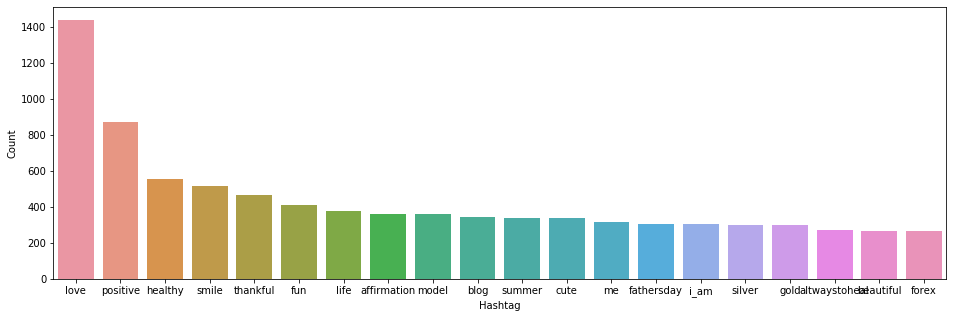

In [19]:
#Select top 20 most frequent hashtags and plot them   
most_frequent = pos_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [20]:
#Repeat same steps for negative tweets

negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
neg_htag = [htag for htag in negative_words.split() if htag.startswith('#')]
neg_htag = [neg_htag[i][1:] for i in range(len(neg_htag))]
neg_htag_freqcount = nltk.FreqDist(neg_htag)
neg_htag_df = pd.DataFrame({'Hashtag' : list(neg_htag_freqcount.keys()),
                            'Count' : list(neg_htag_freqcount.values())})

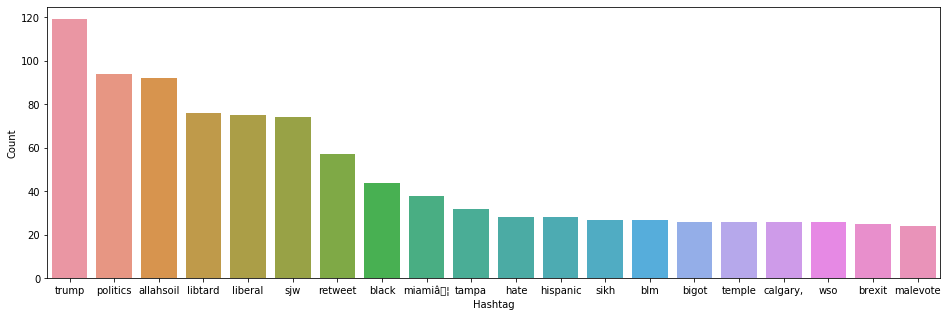

In [21]:
most_frequent = neg_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
plt.show()

Normal words


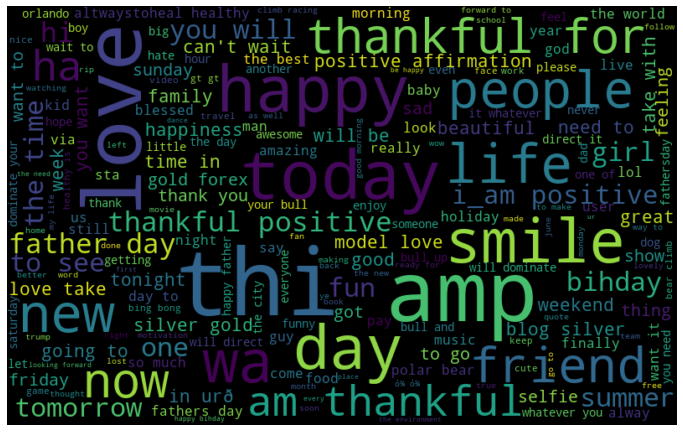

In [22]:
#NORMAL TWEETS
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Negative words


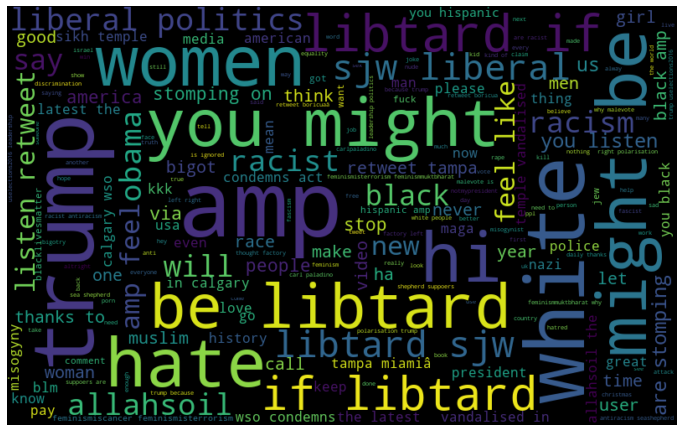

In [26]:
#Racist/Sexist Tweets
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(negative_words)
print('Negative words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [29]:
#BAG OF WORDS
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_tweet'], train['label'], random_state = 0)
X_train.shape, X_val.shape
vect = CountVectorizer().fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [30]:
print('Total features =', len(vect.get_feature_names()))
print(vect.get_feature_names()[::5000])

Total features = 34478
['00', 'btg', 'encouragement', 'ifcarlingdidperfectdays', 'mona', 'rdoequipment', 'technology']


In [31]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<23971x34478 sparse matrix of type '<class 'numpy.int64'>'
	with 266363 stored elements in Compressed Sparse Row format>

In [32]:
#NAIVE'S BAY
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.5725288831835686


In [33]:
#LOGISTIC REGRESSION
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.6441860465116279


In [34]:
#RESCALING _ TI_FD
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5

vect = TfidfVectorizer().fit(X_train)
print('Total Features =', len(vect.get_feature_names()))
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 34478
F1:  0.41907514450867056


In [35]:
#BAG OF WORDS (WITH MORE THAN ONE N_GRAM)
vect = CountVectorizer(min_df = 2, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Total Features =', len(vect.get_feature_names()))

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 38957
F1:  0.6409356725146199


In [ ]:
#HYPER PARAMETER TUNING
pipe = make_pipeline(CountVectorizer(), LogisticRegression())

param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 50, 100],
              "countvectorizer__min_df": [1,2,3],
              "countvectorizer__ngram_range": [(1,1), (1,2), (1,3)]}
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'f1', n_jobs = -1)
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)

In [ ]:
vect = CountVectorizer(min_df = 1, ngram_range = (1,1)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Total Features =', len(vect.get_feature_names()))

model = LogisticRegression(C = 10)
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

In [ ]:
print('Fraction of racist/sexist tweet in train data :', train.label.sum()/len(train))
print('Fraction of racist/sexist tweet predicted by model :', pred.sum()/len(pred))


In [ ]:
pred_prob = model.predict_proba(vect.transform(X_val))
pred = np.where(pred_prob[:,1] > 0.35, 1, 0)
print('Fraction of racist/sexist tweet predicted by model :', sum(pred)/len(pred))
print('F1: ', f1_score(y_val, pred))

In [ ]:
#SMALL CO_EFF AND LARGE CO_EFF
